# Scaffold Evolution Analysis

This notebook analyzes the effectiveness of scaffold evolution in improving crossword solving performance.
We examine how "evolutions" (variations) of scaffolds resulted in higher scores over multiple generations.

In [88]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [89]:
# Load the data
SCORES_FILE = '../experiments/keep_crosswords_20250711_195402/scoring/all_valid_scores.json'
with open(SCORES_FILE, 'r') as f:
    data = json.load(f)

print(f"Loaded data for {len(data)} scaffolds")
print(f"Sample scaffolds: {list(data.keys())[:10]}")

Loaded data for 110 scaffolds
Sample scaffolds: ['5-1-2-0', '1-6', '5-1-1', '5-1-2-1', '5-1-1-0', '5-1-2', '5-1-1-4', '5-1-2-0-0-0', '5-1-2-0-0', '5-1-2-1-1']


In [90]:
# Data processing functions
def parse_scaffold_id(scaffold_id):
    """Parse scaffold ID to extract generation depth and lineage info"""
    parts = scaffold_id.split('-')
    root = parts[0]
    generation = len(parts) - 1
    return root, generation

def get_parent_id(scaffold_id):
    """Get parent scaffold ID"""
    parts = scaffold_id.split('-')
    if len(parts) == 1:
        return None  # No parent for initial scaffolds
    return '-'.join(parts[:-1])

def get_all_ancestors(scaffold_id):
    """Get all ancestor scaffold IDs in order from root to immediate parent"""
    parts = scaffold_id.split('-')
    ancestors = []
    for i in range(1, len(parts)):
        ancestors.append('-'.join(parts[:i]))
    return ancestors

# Create a comprehensive dataframe
scaffold_data = []
for scaffold_id, scaffold_info in data.items():
    root, generation = parse_scaffold_id(scaffold_id)
    parent_id = get_parent_id(scaffold_id)
    
    scaffold_data.append({
        'scaffold_id': scaffold_id,
        'root': root,
        'generation': generation,
        'parent_id': parent_id,
        'mean_score': scaffold_info['mean_score'],
        'scores': scaffold_info['scores'],
        'score_std': np.std(scaffold_info['scores']),
        'num_runs': len(scaffold_info['scores'])
    })

df = pd.DataFrame(scaffold_data)
print(f"Processed {len(df)} scaffolds")
print(f"Generation depths: {sorted(df['generation'].unique())}")
print(f"Root scaffolds: {sorted([int(x) for x in df['root'].unique()])}")

Processed 110 scaffolds
Generation depths: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Root scaffolds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


## 1. Evolution Tree with Score Heatmap

This visualization shows the full evolution tree with nodes colored by mean score. The size of nodes represents the number of descendants (how much the algorithm explored that branch).

In [91]:
# Create network graph for evolution tree
G = nx.DiGraph()

# Add nodes
for _, row in df.iterrows():
    G.add_node(row['scaffold_id'], 
               mean_score=row['mean_score'],
               generation=row['generation'],
               root=row['root'])

# Add edges (parent-child relationships)
for _, row in df.iterrows():
    if row['parent_id'] is not None and row['parent_id'] in data:
        G.add_edge(row['parent_id'], row['scaffold_id'])

# Calculate number of descendants for each node
descendants = {}
for node in G.nodes():
    descendants[node] = len(list(nx.descendants(G, node)))

print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Created graph with 110 nodes and 90 edges


In [99]:
# Plot evolution tree with plotly - CONFIGURABLE PARAMETERS
TREE_NODE_SIZE = 15           # Fixed size for all nodes
TREE_WIDTH = 1200            # Plot width
TREE_HEIGHT = 800            # Plot height
TREE_EDGE_WIDTH = 1          # Edge line width
TREE_TEXT_SIZE = 8           # Label text size
TREE_GEN_SPACING = 3         # Horizontal spacing between generations
TREE_NODE_SPACING = 0.5      # Vertical spacing between nodes

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create layout - separate by generation (same logic as before)
pos = {}
for gen in sorted(df['generation'].unique()):
    gen_nodes = df[df['generation'] == gen]['scaffold_id'].tolist()
    gen_count = len(gen_nodes)
    gen_nodes_df = df[df['generation'] == gen].sort_values(['root', 'scaffold_id'])
    
    for i, (_, row) in enumerate(gen_nodes_df.iterrows()):
        x = gen * TREE_GEN_SPACING  # Horizontal spacing by generation
        y = (i - gen_count/2) * TREE_NODE_SPACING  # Vertical spacing
        pos[row['scaffold_id']] = (x, y)

# Prepare data for plotly
node_x = []
node_y = []
node_scores = []
node_hover = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    score = G.nodes[node]['mean_score']
    desc_count = descendants[node]
    
    node_scores.append(score)
    
    # Create detailed hover info
    hover_info = (f"Scaffold: {node}<br>"
                 f"Mean Score: {score:.4f}<br>"
                 f"Generation: {G.nodes[node]['generation']}<br>"
                 f"Root: {G.nodes[node]['root']}<br>"
                 f"Descendants: {desc_count}")
    node_hover.append(hover_info)

# Prepare edge data
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create the plot
fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter(x=edge_x, y=edge_y,
                         line=dict(width=TREE_EDGE_WIDTH, color='gray'),
                         hoverinfo='none',
                         mode='lines',
                         showlegend=False))

# Add nodes with fixed size
fig.add_trace(go.Scatter(x=node_x, y=node_y,
                         mode='markers+text',
                         marker=dict(
                             size=TREE_NODE_SIZE,  # Fixed size for all nodes
                             color=node_scores,
                             colorscale='RdYlBu_r',
                             colorbar=dict(title="Mean Score"),
                             line=dict(width=1, color='black'),
                             showscale=True
                         ),
                         hovertext=node_hover,
                         hoverinfo='text',
                         showlegend=False))

# Add generation labels
for gen in sorted(df['generation'].unique()):
    fig.add_annotation(
        x=gen * TREE_GEN_SPACING,
        y=max([pos[node][1] for node in pos]) + 1,
        text=f'Gen {gen}',
        showarrow=False,
        font=dict(size=14, color='black'),
        bgcolor='white',
        bordercolor='black',
        borderwidth=1
    )

fig.update_layout(
    title='Interactive Scaffold Evolution Tree<br><sub>Fixed node size, Color = mean score. Hover for details.</sub>',
    showlegend=False,
    width=TREE_WIDTH,
    height=TREE_HEIGHT,
    xaxis=dict(title='Generation', showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    plot_bgcolor='white'
)

fig.show()

print(f"\nTop 10 scaffolds by score:")
top_scaffolds = df.nlargest(10, 'mean_score')[['scaffold_id', 'mean_score', 'generation', 'root']]
print(top_scaffolds.to_string(index=False))


Top 10 scaffolds by score:
scaffold_id  mean_score  generation root
    5-1-2-0    0.799588           3    5
        1-6    0.783902           1    1
      5-1-1    0.775816           2    5
    5-1-2-1    0.771906           3    5
    5-1-1-0    0.771415           3    5
      5-1-2    0.765455           2    5
    5-1-1-4    0.764318           3    5
5-1-2-0-0-0    0.755864           5    5
  5-1-2-0-0    0.748491           4    5
  5-1-2-1-1    0.746541           4    5


## 2. Score Distribution by Generation Depth (Violin Plot + Swarm)

This shows how scores are distributed at each generation level, with each point colored by its root ancestor to show which initial scaffolds led to successful lineages.

In [93]:
# Prepare data for violin plot using mean scores only
plot_data = []
for _, row in df.iterrows():
    plot_data.append({
        'scaffold_id': row['scaffold_id'],
        'generation': row['generation'],
        'root': row['root'],
        'score': row['mean_score'],
        'mean_score': row['mean_score']
    })

plot_df = pd.DataFrame(plot_data)
print(f"Created plot dataframe with {len(plot_df)} scaffolds using mean scores")

# Create color mapping for roots - focus on the most successful roots
root_performance = df.groupby('root')['mean_score'].agg(['mean', 'max', 'count']).sort_values('mean', ascending=False)
print("\nRoot scaffold performance:")
print(root_performance.head(10))

# Get distinct colors for top performing roots
top_roots = root_performance.head(10).index.tolist()
colors = plt.cm.Set3(np.linspace(0, 1, len(top_roots)))
root_colors = {root: colors[i] for i, root in enumerate(top_roots)}
# Gray for all other roots
for root in df['root'].unique():
    if root not in root_colors:
        root_colors[root] = 'lightgray'

Created plot dataframe with 110 scaffolds using mean scores

Root scaffold performance:
          mean       max  count
root                           
12    0.381644  0.688735     14
5     0.372661  0.799588     28
1     0.257743  0.783902     11
10    0.243389  0.486777      2
13    0.241712  0.721408     12
6     0.224828  0.561468      7
8     0.223068  0.648730     17
4     0.204759  0.364634      2
7     0.124972  0.124972      1
18    0.117344  0.117344      1


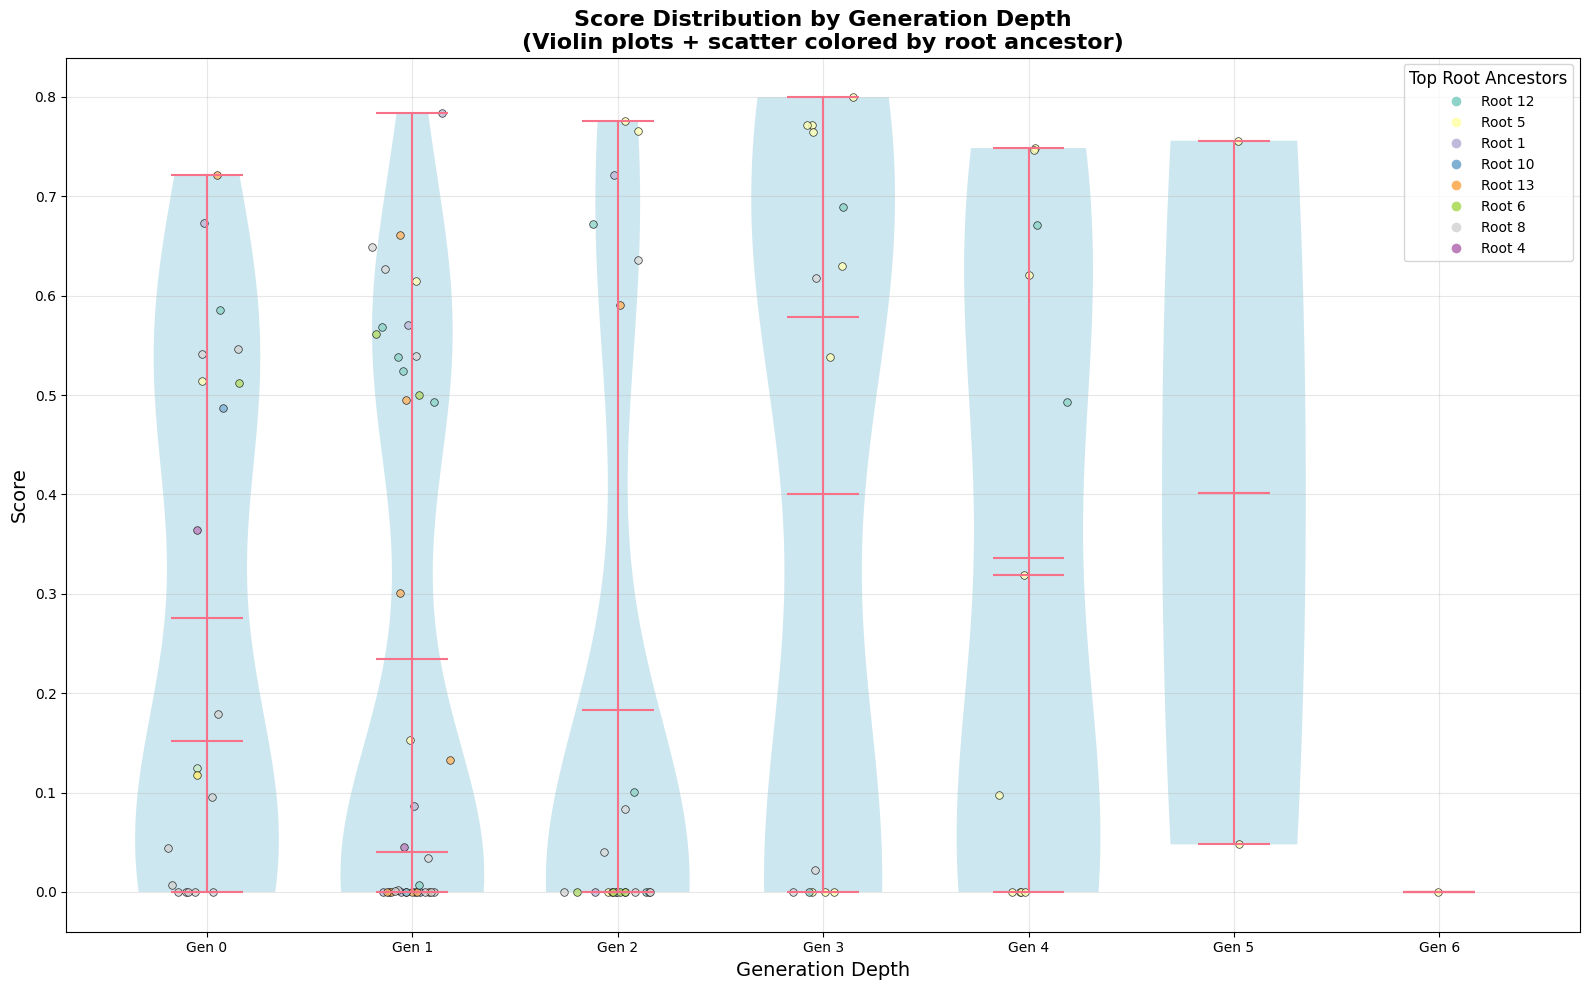


Score statistics by generation:
            count      mean       std       min       max
generation                                               
0              20  0.275641  0.267209  0.000000  0.721408
1              38  0.233960  0.278245  0.000000  0.783902
2              24  0.182711  0.304278  0.000000  0.775816
3              14  0.400332  0.363108  0.000000  0.799588
4              11  0.336016  0.326364  0.000000  0.748491
5               2  0.401866  0.500630  0.047867  0.755864
6               1  0.000000       NaN  0.000000  0.000000


In [94]:
# Violin plot with matplotlib + plotly overlay - CONFIGURABLE PARAMETERS
VIOLIN_WIDTH = 16             # Plot width
VIOLIN_HEIGHT = 10            # Plot height  
SCATTER_SIZE = 30             # Size of scatter points
SCATTER_ALPHA = 0.8           # Transparency of scatter points
JITTER_STRENGTH = 0.1         # Amount of horizontal jitter for scatter points
VIOLIN_ALPHA = 0.6            # Transparency of violin plots

# Create matplotlib violin plot (looks better)
fig_mpl, ax_mpl = plt.subplots(1, 1, figsize=(VIOLIN_WIDTH, VIOLIN_HEIGHT))

# Create violin plot with matplotlib
violin_data_by_gen = [plot_df[plot_df['generation'] == gen]['score'].values 
                      for gen in sorted(plot_df['generation'].unique())]
positions = list(sorted(plot_df['generation'].unique()))

parts = ax_mpl.violinplot(violin_data_by_gen, positions=positions, 
                         widths=0.7, showmeans=True, showmedians=True)

# Color the violin plots
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(VIOLIN_ALPHA)

# Add scatter plot overlay with jitter
np.random.seed(42)  # For reproducible jitter
for gen in sorted(plot_df['generation'].unique()):
    gen_data = plot_df[plot_df['generation'] == gen]
    
    for root in gen_data['root'].unique():
        root_data = gen_data[gen_data['root'] == root]
        
        # Get color for this root (from earlier color mapping)
        if root in root_colors:
            color = root_colors[root]
        else:
            color = 'lightgray'
        
        # Add jitter to x-position
        x_jitter = np.random.normal(gen, JITTER_STRENGTH, len(root_data))
        
        ax_mpl.scatter(x_jitter, root_data['score'], 
                      color=color, 
                      alpha=SCATTER_ALPHA, 
                      s=SCATTER_SIZE, 
                      label=f'Root {root}' if gen == 0 and root in top_roots[:8] else '',
                      edgecolors='black', 
                      linewidth=0.5)

# Formatting matplotlib plot
ax_mpl.set_xlabel('Generation Depth', fontsize=14)
ax_mpl.set_ylabel('Score', fontsize=14)
ax_mpl.set_title('Score Distribution by Generation Depth\n(Violin plots + scatter colored by root ancestor)', 
                fontsize=16, fontweight='bold')

# Set x-axis ticks
generations = sorted(plot_df['generation'].unique())
ax_mpl.set_xticks(generations)
ax_mpl.set_xticklabels([f'Gen {g}' for g in generations])
ax_mpl.grid(True, alpha=0.3)

# Create legend for top roots only
legend_elements = []
for root in top_roots[:8]:
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                     markerfacecolor=root_colors[root], 
                                     markersize=8, label=f'Root {root}'))

ax_mpl.legend(handles=legend_elements, loc='upper right', fontsize=10, 
             title='Top Root Ancestors', title_fontsize=12)

plt.tight_layout()
plt.show()

# Now create a plotly version for hover interactivity
fig_plotly = go.Figure()

# Add scatter points with hover for each generation/root combination
for gen in sorted(plot_df['generation'].unique()):
    gen_data = plot_df[plot_df['generation'] == gen]
    
    for root in gen_data['root'].unique():
        root_data = gen_data[gen_data['root'] == root]
        
        # Get color for this root
        if root in plotly_root_colors:
            color = plotly_root_colors[root]
        else:
            color = 'lightgray'
        
        # Add jitter to x-position (same seed for consistency)
        np.random.seed(42)
        x_jitter = np.random.normal(gen, JITTER_STRENGTH, len(root_data))
        
        # Create hover text
        hover_text = [f"Scaffold: {row['scaffold_id']}<br>"
                     f"Score: {row['score']:.4f}<br>"
                     f"Root: {row['root']}<br>"
                     f"Generation: {row['generation']}"
                     for _, row in root_data.iterrows()]
        
        show_in_legend = bool(gen == 0 and root in top_roots[:8])
        
        fig_plotly.add_trace(go.Scatter(
            x=x_jitter,
            y=root_data['score'],
            mode='markers',
            marker=dict(
                color=color,
                size=8,
                line=dict(width=1, color='black')
            ),
            name=f'Root {root}' if show_in_legend else '',
            hovertext=hover_text,
            hoverinfo='text',
            showlegend=show_in_legend
        ))

fig_plotly.update_layout(
    title='Interactive Score Distribution by Generation Depth<br><sub>Hover over points to see scaffold details. Same data as violin plot above.</sub>',
    xaxis_title='Generation Depth',
    yaxis_title='Mean Score',
    width=1000,
    height=600,
    showlegend=True,
    legend=dict(title='Top Root Ancestors'),
    xaxis=dict(tickmode='array', 
               tickvals=generations, 
               ticktext=[f'Gen {g}' for g in generations])
)

fig_plotly.show()

# Print statistics by generation
print("\nScore statistics by generation:")
generation_stats = plot_df.groupby('generation')['score'].agg(['count', 'mean', 'std', 'min', 'max'])
print(generation_stats)

## 3. Parent-Child Score Improvement Analysis

This scatter plot shows whether evolution generally improves performance. Points above the diagonal line represent improvements over the parent scaffold.

In [95]:
# Prepare parent-child comparison data
parent_child_data = []
for _, row in df.iterrows():
    if row['parent_id'] is not None and row['parent_id'] in data:
        parent_score = data[row['parent_id']]['mean_score']
        child_score = row['mean_score']
        improvement = child_score - parent_score
        
        parent_child_data.append({
            'parent_id': row['parent_id'],
            'child_id': row['scaffold_id'],
            'parent_score': parent_score,
            'child_score': child_score,
            'improvement': improvement,
            'generation': row['generation'],
            'root': row['root'],
            'parent_generation': row['generation'] - 1
        })

pc_df = pd.DataFrame(parent_child_data)
print(f"Found {len(pc_df)} parent-child pairs")
print(f"Improvements: {(pc_df['improvement'] > 0).sum()} positive, {(pc_df['improvement'] < 0).sum()} negative")
print(f"Average improvement: {pc_df['improvement'].mean():.4f}")

Found 90 parent-child pairs
Improvements: 13 positive, 77 negative
Average improvement: -0.3900


In [96]:
# Parent-child improvement analysis - CONFIGURABLE PARAMETERS
PC_PLOT_WIDTH = 1400          # Total plot width
PC_PLOT_HEIGHT = 600          # Plot height
PC_SCATTER_SIZE = 8           # Size of scatter points
PC_TREND_LINE_WIDTH = 2       # Trend line width
PC_REF_LINE_WIDTH = 2         # Reference line width
PC_BAR_OPACITY = 0.7          # Bar chart opacity

# Create interactive parent-child improvement analysis with plotly
from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Parent vs Child Score (All Evolutions)', 'Average Improvement by Parent Score Range'),
    column_widths=[0.6, 0.4]
)

# Left plot: Parent-child scatter
hover_text = [f"Child: {row['child_id']}<br>"
              f"Parent: {row['parent_id']}<br>"
              f"Parent Score: {row['parent_score']:.4f}<br>"
              f"Child Score: {row['child_score']:.4f}<br>"
              f"Improvement: {row['improvement']:.4f}<br>"
              f"Generation: {row['generation']}<br>"
              f"Root: {row['root']}"
              for _, row in pc_df.iterrows()]

fig.add_trace(
    go.Scatter(
        x=pc_df['parent_score'],
        y=pc_df['child_score'],
        mode='markers',
        marker=dict(
            color=pc_df['generation'],
            colorscale='rainbow',
            size=PC_SCATTER_SIZE,
            line=dict(width=1, color='black'),
            colorbar=dict(title="Child Generation", x=0.45)
        ),
        name='Evolutions',
        hovertext=hover_text,
        hoverinfo='text'
    ),
    row=1, col=1
)

# Add diagonal line (no improvement)
min_score = min(pc_df['parent_score'].min(), pc_df['child_score'].min())
max_score = max(pc_df['parent_score'].max(), pc_df['child_score'].max())

fig.add_trace(
    go.Scatter(
        x=[min_score, max_score],
        y=[min_score, max_score],
        mode='lines',
        line=dict(color='red', dash='dash', width=PC_REF_LINE_WIDTH),
        name='No improvement line',
        hoverinfo='skip'
    ),
    row=1, col=1
)

# Add trend line
z = np.polyfit(pc_df['parent_score'], pc_df['child_score'], 1)
trend_y = z[0] * pc_df['parent_score'].sort_values() + z[1]

fig.add_trace(
    go.Scatter(
        x=pc_df['parent_score'].sort_values(),
        y=trend_y,
        mode='lines',
        line=dict(color='blue', width=PC_TREND_LINE_WIDTH),
        name=f'Trend line (slope={z[0]:.3f})',
        hoverinfo='skip'
    ),
    row=1, col=1
)

# Right plot: Improvement by parent score range
pc_df['parent_score_bin'] = pd.cut(pc_df['parent_score'], bins=10)
improvement_by_bin = pc_df.groupby('parent_score_bin')['improvement'].agg(['mean', 'count', 'std'])
improvement_by_bin = improvement_by_bin.dropna()

bin_centers = [interval.mid for interval in improvement_by_bin.index]
mean_improvements = improvement_by_bin['mean'].values
counts = improvement_by_bin['count'].values
stds = improvement_by_bin['std'].fillna(0).values

colors = ['green' if x > 0 else 'red' for x in mean_improvements]

fig.add_trace(
    go.Bar(
        x=bin_centers,
        y=mean_improvements,
        error_y=dict(type='data', array=stds, visible=True),
        marker_color=colors,
        marker_line=dict(color='black', width=1),
        opacity=PC_BAR_OPACITY,
        name='Improvement by bin',
        hovertemplate='Parent Score Range: %{x:.3f}<br>Mean Improvement: %{y:.4f}<br>Count: %{text}<extra></extra>',
        text=counts
    ),
    row=1, col=2
)

# Add horizontal line at y=0
fig.add_hline(y=0, line_dash="solid", line_color="black", row=1, col=2)

# Update layout
fig.update_layout(
    title='Parent-Child Score Improvement Analysis<br><sub>Left: Individual evolutions (hover for details). Right: Binned improvements.</sub>',
    width=PC_PLOT_WIDTH,
    height=PC_PLOT_HEIGHT,
    showlegend=True
)

fig.update_xaxes(title_text="Parent Score", row=1, col=1)
fig.update_yaxes(title_text="Child Score", row=1, col=1)
fig.update_xaxes(title_text="Parent Score Range", row=1, col=2)
fig.update_yaxes(title_text="Average Score Improvement", row=1, col=2)

fig.show()

# Print detailed improvement statistics
print("\nImprovement analysis:")
print(f"Total evolutions: {len(pc_df)}")
print(f"Positive improvements: {(pc_df['improvement'] > 0).sum()} ({(pc_df['improvement'] > 0).mean()*100:.1f}%)")
print(f"Negative improvements: {(pc_df['improvement'] < 0).sum()} ({(pc_df['improvement'] < 0).mean()*100:.1f}%)")
print(f"No change: {(pc_df['improvement'] == 0).sum()}")
print(f"Average improvement: {pc_df['improvement'].mean():.4f} ± {pc_df['improvement'].std():.4f}")
print(f"Median improvement: {pc_df['improvement'].median():.4f}")

print("\nImprovement by generation:")
gen_improvements = pc_df.groupby('generation')['improvement'].agg(['count', 'mean', 'std'])
print(gen_improvements)


Improvement analysis:
Total evolutions: 90
Positive improvements: 13 (14.4%)
Negative improvements: 77 (85.6%)
No change: 0
Average improvement: -0.3900 ± 0.3143
Median improvement: -0.5451

Improvement by generation:
            count      mean       std
generation                           
1              38 -0.364687  0.300876
2              24 -0.437317  0.304887
3              14 -0.327683  0.350089
4              11 -0.428139  0.342992
5               2 -0.346625  0.500630
6               1 -0.755864       NaN


## 4. Score Consistency vs Performance Analysis

This scatter plot shows the relationship between mean performance and score consistency (standard deviation). Points in the bottom-right represent the ideal: high performance with low variability.

In [97]:
# Score Consistency vs Performance Analysis - CONFIGURABLE PARAMETERS
CONSISTENCY_WIDTH = 900       # Plot width
CONSISTENCY_HEIGHT = 600      # Plot height
CONSISTENCY_MARKER_SIZE = 8   # Size of scatter points
CONSISTENCY_LINE_WIDTH = 1    # Marker border width

# Score Consistency vs Performance Analysis (Interactive with Plotly)
# Create enhanced dataframe with hover information
df_plot = df.copy()
df_plot['hover_text'] = df_plot.apply(lambda row: 
    f"Scaffold: {row['scaffold_id']}<br>" +
    f"Mean Score: {row['mean_score']:.4f}<br>" +
    f"Std Dev: {row['score_std']:.4f}<br>" +
    f"Generation: {row['generation']}<br>" +
    f"Root: {row['root']}<br>" +
    f"Individual Scores: {', '.join([f'{s:.3f}' for s in row['scores']])}", 
    axis=1)

# Create the interactive scatter plot
fig = px.scatter(df_plot, 
                 x='mean_score', 
                 y='score_std',
                 color='generation',
                 color_continuous_scale='rainbow_r',
                 hover_name='scaffold_id',
                 hover_data={
                     'mean_score': ':.4f',
                     'score_std': ':.4f', 
                     'generation': True,
                     'root': True
                 },
                 title='Score Consistency vs Performance<br><sub>Hover over points to see scaffold details. Colored by generation depth.</sub>',
                 labels={
                     'mean_score': 'Mean Score',
                     'score_std': 'Standard Deviation of Scores',
                     'generation': 'Generation'
                 })

# Update traces for better appearance
fig.update_traces(marker=dict(size=CONSISTENCY_MARKER_SIZE, 
                             line=dict(width=CONSISTENCY_LINE_WIDTH, color='black')))

# Add reference lines
median_score = df['mean_score'].median()
median_std = df['score_std'].median()

fig.add_hline(y=median_std, line_dash="dash", line_color="gray", 
              annotation_text=f"Median std dev ({median_std:.3f})",
              annotation_position="bottom left")
fig.add_vline(x=median_score, line_dash="dash", line_color="gray",
              annotation_text=f"Median mean score ({median_score:.3f})",
              annotation_position="top left")

# Add quadrant annotations
fig.add_annotation(x=0.05, y=0.95, xref="paper", yref="paper",
                   text="Low Performance<br>High Variance", showarrow=False,
                   bgcolor="white", bordercolor="black", borderwidth=1)
fig.add_annotation(x=0.95, y=0.95, xref="paper", yref="paper", 
                   text="High Performance<br>High Variance", showarrow=False,
                   bgcolor="white", bordercolor="black", borderwidth=1)
fig.add_annotation(x=0.05, y=0.05, xref="paper", yref="paper",
                   text="Low Performance<br>Low Variance", showarrow=False,
                   bgcolor="white", bordercolor="black", borderwidth=1)
fig.add_annotation(x=0.95, y=0.05, xref="paper", yref="paper",
                   text="High Performance<br>Low Variance<br><b>(IDEAL)</b>", showarrow=False,
                   bgcolor="lightgreen", bordercolor="black", borderwidth=1)

# Update layout
fig.update_layout(
    width=CONSISTENCY_WIDTH,
    height=CONSISTENCY_HEIGHT,
    showlegend=True,
    font=dict(size=12)
)

fig.show()

# Print analysis (same as before)
print("SCORE CONSISTENCY ANALYSIS:")
print("=" * 50)
print(f"Most consistent scaffold: {df.loc[df['score_std'].idxmin(), 'scaffold_id']} (std: {df['score_std'].min():.4f})")
print(f"Most variable scaffold: {df.loc[df['score_std'].idxmax(), 'scaffold_id']} (std: {df['score_std'].max():.4f})")
print(f"\nTop 5 most consistent scaffolds:")
most_consistent = df.nsmallest(5, 'score_std')[['scaffold_id', 'mean_score', 'score_std', 'generation']]
print(most_consistent.to_string(index=False))

print(f"\nTop 5 performers with low variance (std < 0.1):")
reliable_performers = df[df['score_std'] < 0.1].nlargest(5, 'mean_score')[['scaffold_id', 'mean_score', 'score_std', 'generation']]
if len(reliable_performers) > 0:
    print(reliable_performers.to_string(index=False))
else:
    print("No scaffolds found with std < 0.1")

print(f"\nCorrelation between mean score and std dev: {df['mean_score'].corr(df['score_std']):.4f}")

# Check if later generations are more consistent
generation_consistency = df.groupby('generation')['score_std'].agg(['mean', 'median', 'count'])
print(f"\nConsistency by generation:")
print(generation_consistency)

SCORE CONSISTENCY ANALYSIS:
Most consistent scaffold: 11-1 (std: 0.0000)
Most variable scaffold: 5-1-1-0-2 (std: 0.3908)

Top 5 most consistent scaffolds:
scaffold_id  mean_score  score_std  generation
       11-1         0.0        0.0           1
    5-1-2-3         0.0        0.0           3
    5-1-1-3         0.0        0.0           3
        1-4         0.0        0.0           1
       11-0         0.0        0.0           1

Top 5 performers with low variance (std < 0.1):
scaffold_id  mean_score  score_std  generation
    5-1-2-0    0.799588   0.043730           3
        1-6    0.783902   0.034878           1
      5-1-1    0.775816   0.064333           2
    5-1-2-1    0.771906   0.049864           3
    5-1-1-0    0.771415   0.060892           3

Correlation between mean score and std dev: 0.4115

Consistency by generation:
                mean    median  count
generation                           
0           0.062092  0.054049     20
1           0.060851  0.034038     38


## Summary Statistics and Insights

Comprehensive analysis of the scaffold evolution experiment results.

In [98]:
# Summary insights
print("=" * 60)
print("SCAFFOLD EVOLUTION ANALYSIS SUMMARY")
print("=" * 60)

print("\n1. OVERALL EVOLUTION EFFECTIVENESS:")
success_rate = (pc_df['improvement'] > 0).mean() * 100
print(f"   • Evolution success rate: {success_rate:.1f}% of evolutions improved over parent")
print(f"   • Average improvement per evolution: {pc_df['improvement'].mean():.4f}")
print(f"   • Best improvement: +{pc_df['improvement'].max():.4f}")
print(f"   • Worst regression: {pc_df['improvement'].min():.4f}")

print("\n2. EXPLORATION STATISTICS:")
print(f"   • Total scaffolds tested: {len(df)}")
print(f"   • Maximum generation depth: {df['generation'].max()}")
print(f"   • Most explored root: Root {df.groupby('root').size().idxmax()} ({df.groupby('root').size().max()} scaffolds)")

top_lineage = df[df['root'] == df.groupby('root').size().idxmax()].sort_values('mean_score', ascending=False).iloc[0]
print(f"   • Best scaffold from most explored root: {top_lineage['scaffold_id']} (score: {top_lineage['mean_score']:.4f})")

print("\n3. PERFORMANCE BY GENERATION:")
for gen in sorted(df['generation'].unique()):
    gen_df = df[df['generation'] == gen]
    print(f"   • Generation {gen}: {len(gen_df)} scaffolds, mean score {gen_df['mean_score'].mean():.4f}, best {gen_df['mean_score'].max():.4f}")

print("\n4. ROOT SCAFFOLD RANKINGS:")
root_rankings = df.groupby('root').agg({
    'mean_score': ['count', 'mean', 'max'],
    'generation': 'max'
}).round(4)
root_rankings.columns = ['Descendants', 'Avg_Score', 'Best_Score', 'Max_Gen']
root_rankings = root_rankings.sort_values('Best_Score', ascending=False)
print(root_rankings.head(10))

print("\n5. KEY INSIGHTS:")
if pc_df['improvement'].mean() > 0:
    print(f"   • Evolution is generally effective (positive average improvement)")
else:
    print(f"   • Evolution shows mixed results (negative average improvement)")

if df.groupby('generation')['mean_score'].mean().is_monotonic_increasing:
    print(f"   • Later generations consistently perform better")
else:
    print(f"   • Performance doesn't consistently improve with generation depth")

best_scaffold = df.loc[df['mean_score'].idxmax()]
print(f"   • Best overall scaffold: {best_scaffold['scaffold_id']} (score: {best_scaffold['mean_score']:.4f}, generation: {best_scaffold['generation']})")

print(f"   • Algorithm focused on root {df.groupby('root').size().idxmax()} which {'was' if df.groupby('root')['mean_score'].mean().idxmax() == df.groupby('root').size().idxmax() else 'was not'} the most promising initially")

SCAFFOLD EVOLUTION ANALYSIS SUMMARY

1. OVERALL EVOLUTION EFFECTIVENESS:
   • Evolution success rate: 14.4% of evolutions improved over parent
   • Average improvement per evolution: -0.3900
   • Best improvement: +0.1606
   • Worst regression: -0.7996

2. EXPLORATION STATISTICS:
   • Total scaffolds tested: 110
   • Maximum generation depth: 6
   • Most explored root: Root 5 (28 scaffolds)
   • Best scaffold from most explored root: 5-1-2-0 (score: 0.7996)

3. PERFORMANCE BY GENERATION:
   • Generation 0: 20 scaffolds, mean score 0.2756, best 0.7214
   • Generation 1: 38 scaffolds, mean score 0.2340, best 0.7839
   • Generation 2: 24 scaffolds, mean score 0.1827, best 0.7758
   • Generation 3: 14 scaffolds, mean score 0.4003, best 0.7996
   • Generation 4: 11 scaffolds, mean score 0.3360, best 0.7485
   • Generation 5: 2 scaffolds, mean score 0.4019, best 0.7559
   • Generation 6: 1 scaffolds, mean score 0.0000, best 0.0000

4. ROOT SCAFFOLD RANKINGS:
      Descendants  Avg_Score  Bes